In [47]:
root = '/home/fesiib/doc2slide/dev/intro_to_dl_project'

import os
from pathlib import Path

import numpy as np

import torch

from torch.utils.data import DataLoader

from preprocess_root import init_dataset
from model import SlideDeckEncoder
from model_no_encoder import Generator, Discriminator

from utils_transformer import SortByRefSlide, draw_bbs, get_Tensor, get_device, get_args

device = get_device()
args = get_args()
Tensor = get_Tensor()

result_dir = Path(root) / 'results'

In [66]:
def load_chekpoint(path, models, optimizers):
    path = os.path.join(path, 'checkpoint_499.pt')
    print(path)
    try:
       checkpoint = torch.load(path)
    except:
        print("Couldn't load the last checkpoint!")
        return models, optimizers, -1

    models['encoder'].load_state_dict(checkpoint['model_encoder_state_dict'])
    models['discriminator'].load_state_dict(checkpoint['model_discriminator_state_dict'])
    models['generator'].load_state_dict(checkpoint['model_generator_state_dict'])
    
    optimizers['encoder'].load_state_dict(checkpoint['optimizer_encoder_state_dict'])
    optimizers['generator'].load_state_dict(checkpoint['optimizer_generator_state_dict'])
    optimizers['discriminator'].load_state_dict(checkpoint['optimizer_discriminator_state_dict'])
    epoch = checkpoint['epoch']

    return models, optimizers, epoch

In [65]:
(train_dataset, test_dataset) = init_dataset(root, args.normalized)
test_loader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=True, drop_last=True)

/home/fesiib/doc2slide/dev/intro_to_dl_project/data/bbs
file:  slide_deck_dataset_bmvc13.csv
file:  slide_deck_dataset_nips18.csv
file:  slide_deck_dataset_cvpr20.csv
file:  slide_deck_dataset_acl20.csv
file:  slide_deck_dataset_emnlp18.csv
file:  slide_deck_dataset_naacl19.csv
file:  slide_deck_dataset_eccv20.csv
file:  slide_deck_dataset_acl17.csv
file:  slide_deck_dataset_iclr20.csv
file:  slide_deck_dataset_cvpr10.csv
file:  slide_deck_dataset_eccv12.csv
file:  slide_deck_dataset_bmvc12.csv
file:  slide_deck_dataset_icml19.csv
file:  slide_deck_dataset_acl18.csv
file:  slide_deck_dataset_eccv14.csv
file:  slide_deck_dataset_icml20.csv
file:  slide_deck_dataset_fg15.csv
file:  slide_deck_dataset_emnlp17.csv
file:  slide_deck_dataset_nips19.csv
26820
7780


In [67]:


encoder = SlideDeckEncoder(
    args.num_label, args.slide_deck_embedding_size, args.slide_deck_N, args.padding_idx, 
    args.D_d_model, args.D_nhead, args.D_num_layers
).to(device)

generator = Generator(
    args.latent_size, args.num_label, args.slide_deck_embedding_size, args.padding_idx,
    d_model=args.G_d_model,
    nhead=args.G_nhead,
    num_layers=args.G_num_layers,
).to(device)

discriminator = Discriminator(
    args.num_label, args.slide_deck_embedding_size, args.max_seq_length, args.padding_idx,
    d_model=args.D_d_model,
    nhead=args.D_nhead,
    num_layers=args.D_num_layers,
).to(device)

models = {
    "discriminator": discriminator,
    "encoder" : encoder,
    "generator" : generator,
}

optimizers = {
    "discriminator": torch.optim.Adam(models["discriminator"].parameters(), lr=args.lr),
    "generator": torch.optim.Adam(models["generator"].parameters(), lr=args.lr),
    "encoder" : torch.optim.Adam(models["encoder"].parameters(), lr=args.lr)
}


parent_dir = result_dir / 'trial_transf_2'


(models, optimizers, loaded_epoch) = load_chekpoint(parent_dir, models, optimizers)

print(f"Loaded Epoch: {loaded_epoch} from {parent_dir}")

/home/fesiib/doc2slide/dev/intro_to_dl_project/results/trial_transf_2/checkpoint_499.pt
Loaded Epoch: 499 from /home/fesiib/doc2slide/dev/intro_to_dl_project/results/trial_transf_2


In [68]:
for model in models:
    models[model].eval()

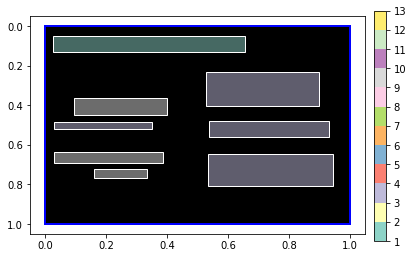

In [81]:
batch = list(test_loader)[0]
batch = SortByRefSlide(batch)
shape = batch["shape"].to(device)
slide_deck = batch["slide_deck"].to(device)
lengths_slide_deck = batch["lengths_slide_deck"].to(device)
ref_length = batch["length_ref_types"].to(device)
ref_types = batch["ref_types"].to(device).long()
ref_slide = batch["ref_slide"].to(device)

# deck encdoing
slide_deck = torch.transpose(slide_deck, 0, 1)
lengths_slide_deck = torch.transpose(lengths_slide_deck, 0, 1)
bboxes = slide_deck[:, :, :, :-1]
labels = slide_deck[:, :, :, -1].long()
padding_masks = ~(lengths_slide_deck[:, :, None] > torch.arange(labels.size(2)).to(device)[None, :])
models['encoder'].zero_grad()
deck_enc = models['encoder'](bboxes, labels, padding_masks)

label = ref_types

padding_mask = ~(ref_length[:, None] > torch.arange(label.size(1)).to(device)[None, :])
bbox_real = ref_slide[:, :, :-1]

n = 4
real_layouts_bbs = ref_slide[:,:,:-1]

draw_bbs(shape[n],real_layouts_bbs[n], ref_types[n], False)

tensor([[[ 1.0837, -1.0571,  0.5604,  0.2416],
         [ 0.9682, -1.7306, -0.9543,  1.3955],
         [ 0.6333, -0.0039, -0.7518, -1.1744],
         [-0.1171, -0.6905, -1.0832, -1.6697],
         [ 1.1066,  0.3967,  0.7037,  0.7035],
         [-0.1394, -1.2934, -0.5862,  0.8822],
         [-0.4164,  0.1616,  0.1840,  1.1194],
         [ 1.5452,  0.6333, -2.0521,  3.6355]]], device='cuda:0') tensor([[3, 3, 3, 9, 1, 9, 3, 9]], device='cuda:0') tensor([[False, False, False, False, False, False, False, False]],
       device='cuda:0')
tensor([[[0.1129, 0.2024, 0.7487, 0.1200],
         [0.1126, 0.1987, 0.7521, 0.1284],
         [0.1121, 0.1965, 0.7534, 0.1287],
         [0.2458, 0.4996, 0.5158, 0.4034],
         [0.2883, 0.0383, 0.4149, 0.0611],
         [0.2413, 0.5047, 0.5206, 0.3994],
         [0.1129, 0.2005, 0.7510, 0.1266],
         [0.2320, 0.5111, 0.5329, 0.3934]]], device='cuda:0')


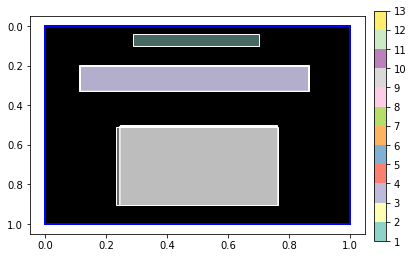

tensor([[[ 0.6701,  1.3873,  1.0289, -1.1015],
         [-0.5450,  0.2267, -2.2281,  1.1862],
         [ 1.4078,  0.8863, -0.6008,  0.0936],
         [-0.5910,  0.5461,  1.4594, -1.6386],
         [-0.4753, -0.2606, -0.5479, -0.3339],
         [ 1.2844, -1.8981, -2.4746,  0.0402],
         [-1.8414, -0.1097,  0.1138, -0.1703],
         [-1.2154,  0.5141, -1.6566,  0.5767]]], device='cuda:0') tensor([[3, 3, 3, 9, 1, 9, 3, 9]], device='cuda:0') tensor([[False, False, False, False, False, False, False, False]],
       device='cuda:0')
tensor([[[0.2789, 0.7853, 0.4200, 0.0343],
         [0.2841, 0.7895, 0.4113, 0.0385],
         [0.2795, 0.7858, 0.4192, 0.0347],
         [0.2241, 0.1714, 0.5243, 0.4858],
         [0.2702, 0.0438, 0.4591, 0.0562],
         [0.2210, 0.1721, 0.5291, 0.4958],
         [0.2869, 0.7927, 0.4060, 0.0382],
         [0.2232, 0.1717, 0.5254, 0.4918]]], device='cuda:0')


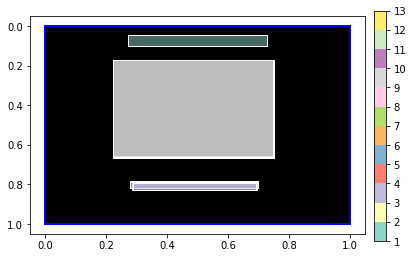

tensor([[[-0.6348, -1.7168,  0.6830, -0.0204],
         [-0.6652,  0.9269,  1.2181, -1.1207],
         [ 1.0393, -0.9408, -0.2641,  1.3247],
         [ 0.1706, -0.3080,  1.0080,  1.4660],
         [ 1.0040, -0.3593, -1.0036,  0.0126],
         [ 0.3890,  0.3109,  0.6724,  0.2068],
         [-0.1832,  0.7452,  1.1362, -0.4359],
         [-1.3763, -0.1114,  0.8388, -0.9839]]], device='cuda:0') tensor([[3, 3, 3, 9, 1, 9, 3, 9]], device='cuda:0') tensor([[False, False, False, False, False, False, False, False]],
       device='cuda:0')
tensor([[[0.3001, 0.7748, 0.3852, 0.0351],
         [0.3040, 0.7782, 0.3777, 0.0362],
         [0.3103, 0.7877, 0.3622, 0.0373],
         [0.2272, 0.1742, 0.5180, 0.5056],
         [0.2748, 0.0442, 0.4495, 0.0561],
         [0.2274, 0.1741, 0.5176, 0.5050],
         [0.3100, 0.7863, 0.3634, 0.0373],
         [0.2280, 0.1740, 0.5157, 0.5058]]], device='cuda:0')


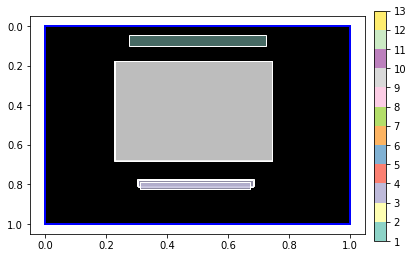

tensor([[[-1.2467, -2.3788,  0.9694,  0.0115],
         [ 2.2677, -1.4462, -0.3715, -0.6496],
         [-1.0851,  1.9034,  0.2476, -0.7529],
         [-0.5399,  0.9472, -0.4018,  0.1606],
         [-2.0593, -0.9055,  0.7381, -0.4430],
         [-0.2648, -0.0430,  0.5852,  0.2314],
         [-0.2472,  1.8024, -2.2638, -1.0162],
         [-0.7092, -0.3904, -0.2502, -0.6198]]], device='cuda:0') tensor([[3, 3, 3, 9, 1, 9, 3, 9]], device='cuda:0') tensor([[False, False, False, False, False, False, False, False]],
       device='cuda:0')
tensor([[[0.2347, 0.8092, 0.4887, 0.0355],
         [0.2215, 0.7872, 0.5180, 0.0342],
         [0.2301, 0.8005, 0.5004, 0.0351],
         [0.1985, 0.1783, 0.5745, 0.4767],
         [0.2617, 0.0458, 0.4775, 0.0567],
         [0.1974, 0.1785, 0.5767, 0.4754],
         [0.2290, 0.7953, 0.5085, 0.0367],
         [0.1976, 0.1785, 0.5764, 0.4764]]], device='cuda:0')


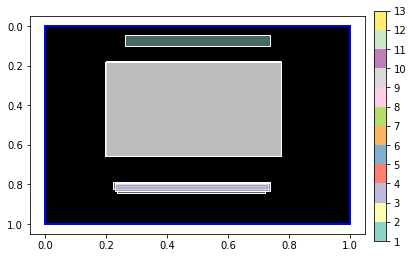

tensor([[[ 1.1675, -1.5594, -0.8621,  1.2724],
         [ 0.0241, -1.1393,  1.4130,  0.1718],
         [ 0.4892, -0.4151, -0.1984,  0.1932],
         [ 0.9771, -2.0448,  0.1536, -0.1559],
         [ 0.8112, -1.4232, -0.0992, -1.0068],
         [ 0.6690,  0.6465,  1.4626, -1.1297],
         [ 1.4548, -0.8277,  0.8620, -1.3046],
         [ 0.2594,  0.2235,  1.1386,  0.7071]]], device='cuda:0') tensor([[3, 3, 3, 9, 1, 9, 3, 9]], device='cuda:0') tensor([[False, False, False, False, False, False, False, False]],
       device='cuda:0')
tensor([[[0.3085, 0.7837, 0.3693, 0.0355],
         [0.3094, 0.7855, 0.3672, 0.0360],
         [0.3076, 0.7830, 0.3709, 0.0350],
         [0.2267, 0.1735, 0.5201, 0.5019],
         [0.2697, 0.0445, 0.4604, 0.0564],
         [0.2296, 0.1731, 0.5151, 0.4995],
         [0.3045, 0.7800, 0.3772, 0.0339],
         [0.2284, 0.1733, 0.5170, 0.5015]]], device='cuda:0')


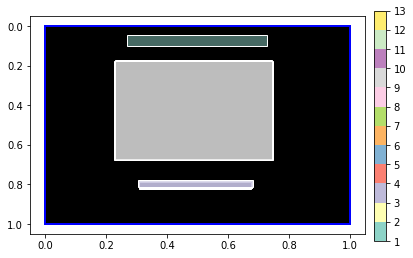

tensor([[[-0.6632,  1.6740, -1.1778, -0.7388],
         [ 0.5412,  0.8399, -0.1369,  0.0418],
         [-1.5578,  0.2100, -0.1483,  1.0711],
         [ 1.6007, -0.4484, -0.0414, -0.8419],
         [ 0.4240,  0.1093,  0.5738, -1.3968],
         [ 0.3492, -2.3036,  1.1116, -0.4782],
         [-0.6158,  1.0960, -0.8868,  0.2585],
         [-1.3836, -0.0438,  1.2321, -1.3379]]], device='cuda:0') tensor([[3, 3, 3, 9, 1, 9, 3, 9]], device='cuda:0') tensor([[False, False, False, False, False, False, False, False]],
       device='cuda:0')
tensor([[[0.1084, 0.2019, 0.7185, 0.0787],
         [0.1185, 0.8304, 0.6098, 0.0618],
         [0.1093, 0.2029, 0.7169, 0.0788],
         [0.2357, 0.4232, 0.5259, 0.4081],
         [0.2714, 0.0466, 0.4528, 0.0568],
         [0.2378, 0.4235, 0.5226, 0.4082],
         [0.1126, 0.2505, 0.6456, 0.0601],
         [0.2425, 0.4204, 0.5174, 0.4068]]], device='cuda:0')


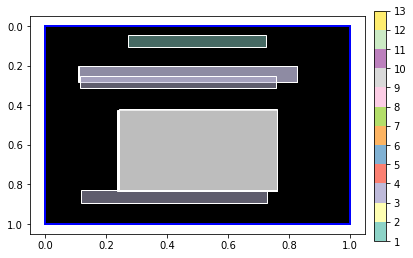

tensor([[[-2.2020, -0.4810,  0.8929,  1.2834],
         [ 1.3064, -1.8921, -1.0746,  1.1886],
         [ 0.0752,  0.4350, -0.8819,  0.4055],
         [-0.9362,  1.0362,  0.1374,  0.4034],
         [-1.7090,  0.1951, -0.0625,  0.4670],
         [-0.9199,  0.0125,  0.3058, -0.0277],
         [-0.6905, -0.7373, -0.0190,  0.4380],
         [-0.5130,  0.5075, -0.7959,  0.5922]]], device='cuda:0') tensor([[3, 3, 3, 9, 1, 9, 3, 9]], device='cuda:0') tensor([[False, False, False, False, False, False, False, False]],
       device='cuda:0')
tensor([[[0.1113, 0.1957, 0.7077, 0.0898],
         [0.1273, 0.7835, 0.5463, 0.0565],
         [0.1251, 0.7789, 0.5488, 0.0581],
         [0.2454, 0.3739, 0.4974, 0.3461],
         [0.2756, 0.0457, 0.4454, 0.0561],
         [0.2443, 0.3763, 0.4978, 0.3475],
         [0.1238, 0.7791, 0.5428, 0.0582],
         [0.2441, 0.3766, 0.4979, 0.3476]]], device='cuda:0')


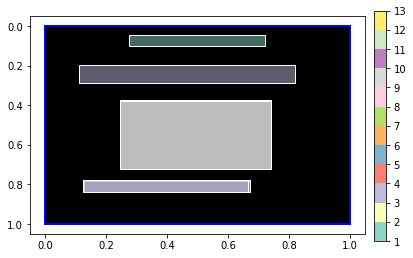

tensor([[[ 0.8779,  0.9013,  1.3194,  0.9384],
         [ 1.2036, -0.0259, -1.0986,  0.8998],
         [ 0.6168,  1.3605, -1.0403,  0.1124],
         [ 0.2957,  2.0726,  0.3498,  1.2905],
         [-1.3330, -1.7097,  0.0279,  0.6887],
         [-0.7186, -0.4158, -0.4201,  0.4807],
         [-0.5378, -0.7505, -1.5460, -0.2603],
         [-1.3665, -0.2604,  0.4871,  0.7915]]], device='cuda:0') tensor([[3, 3, 3, 9, 1, 9, 3, 9]], device='cuda:0') tensor([[False, False, False, False, False, False, False, False]],
       device='cuda:0')
tensor([[[0.2608, 0.8007, 0.4489, 0.0344],
         [0.2588, 0.7980, 0.4537, 0.0343],
         [0.2585, 0.7969, 0.4562, 0.0344],
         [0.2159, 0.1766, 0.5396, 0.4834],
         [0.2689, 0.0450, 0.4621, 0.0563],
         [0.2149, 0.1769, 0.5409, 0.4889],
         [0.2632, 0.8010, 0.4462, 0.0351],
         [0.2156, 0.1767, 0.5398, 0.4855]]], device='cuda:0')


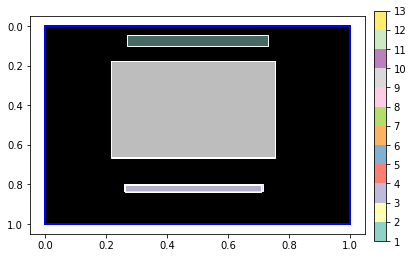

tensor([[[-0.3012, -0.4845, -0.3379, -1.7505],
         [ 0.3030, -0.8253, -0.0047, -0.3180],
         [ 1.2853, -0.8963, -0.4622,  1.2639],
         [ 1.5480, -0.2579,  1.0109, -0.7674],
         [-0.1023, -0.1099, -0.7661, -0.2271],
         [-0.5491, -0.6617,  0.5914,  1.1415],
         [-0.5778, -0.4253, -0.3380, -2.4486],
         [ 1.0803,  1.0402, -0.0620, -1.2150]]], device='cuda:0') tensor([[3, 3, 3, 9, 1, 9, 3, 9]], device='cuda:0') tensor([[False, False, False, False, False, False, False, False]],
       device='cuda:0')
tensor([[[0.3015, 0.7767, 0.3816, 0.0373],
         [0.3027, 0.7793, 0.3787, 0.0366],
         [0.3030, 0.7799, 0.3781, 0.0367],
         [0.2268, 0.1713, 0.5202, 0.4972],
         [0.2721, 0.0440, 0.4551, 0.0563],
         [0.2271, 0.1714, 0.5194, 0.4982],
         [0.2977, 0.7738, 0.3884, 0.0373],
         [0.2281, 0.1712, 0.5180, 0.4958]]], device='cuda:0')


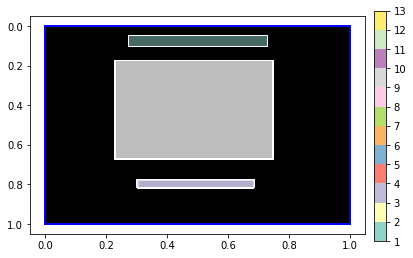

tensor([[[ 0.6404,  0.3617, -1.3460, -1.1597],
         [-0.1218,  0.0415, -0.3038, -0.6228],
         [-1.0394, -1.4721,  0.1220, -1.2087],
         [ 0.9088,  0.7738,  0.0144,  1.2206],
         [ 0.3462,  0.1907,  1.8105, -0.6263],
         [-0.1351, -0.2823,  0.0499,  1.5828],
         [ 0.9411, -1.5803,  0.0204,  0.8435],
         [ 1.0697, -1.6674,  2.7954, -0.2878]]], device='cuda:0') tensor([[3, 3, 3, 9, 1, 9, 3, 9]], device='cuda:0') tensor([[False, False, False, False, False, False, False, False]],
       device='cuda:0')
tensor([[[0.1083, 0.2019, 0.7309, 0.0960],
         [0.1110, 0.2480, 0.6715, 0.0736],
         [0.1086, 0.1977, 0.7384, 0.1032],
         [0.2172, 0.5068, 0.5535, 0.3986],
         [0.2828, 0.0495, 0.4280, 0.0602],
         [0.2211, 0.5069, 0.5473, 0.3994],
         [0.1117, 0.2743, 0.6403, 0.0648],
         [0.2637, 0.4896, 0.4904, 0.4167]]], device='cuda:0')


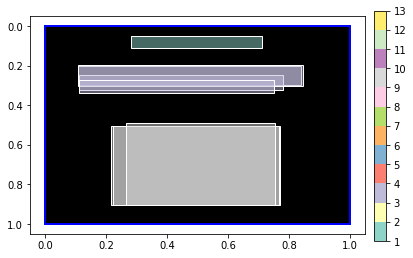

In [82]:
for i in range(10):
    z = torch.autograd.Variable(Tensor(np.random.normal(0, 1, (label.size(0), label.size(1), args.latent_size))))

    optimizers["encoder"].zero_grad()
    optimizers["discriminator"].zero_grad()

    # Sample noise as generator input
    fake_layouts_bbs = models['generator'](z[n:n+1], label[n:n+1], padding_mask[n:n+1]).detach()
    print(z[n:n+1], label[n:n+1], padding_mask[n:n+1])
    print(fake_layouts_bbs)
    draw_bbs(shape[n], fake_layouts_bbs[0], ref_types[n], False)